# 21COC102 - Advanced Artificial Intelligent Systems
<br>


## Base Model
<br>
https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/
<br>
Base model used  (I like his tutorials alot and has helped me learn and understand AI in depth in the past)

In [12]:
import numpy as py
from matplotlib import pyplot as plt
import keras

#MNIST data set and tensorflow
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

The MNIST dataset contains 60,000 pre-aligned greyscale 28x28 pixel images. <br>
Since there are 10 outputs/classes that are represented as integers, to_categorical function can be used to transform the integer into a binary vector with 10 elements.
<br><br>
Load the MNIST dataset, and reshape into a single colour channel.

In [2]:
#load data and reshape 
def loadMNIST():
    #load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    #reshape
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    print("MNIST loaded")
    return trainX, trainY, testX, testY

The pixel values are values between 0 to 255, black to white. The method used to scale will be to normalise the pixel values to the range [0,1]
<br><br>Normalise the pixel values (0 to 255) to [0,1]

In [3]:
#scale and normalise pixels
def pixel(train, test):
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    #normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    #return normalized images
    return train_norm, test_norm

The model used as the base has 2 main aspects: the feature-extraction front-end, containing convolutional and pooling layers, and the classifier back-end that makes the prediction. <br>
Within the front-end, testing has shown that using 32 feature maps and a 5x5 filter is optimal, followed by a max pooling layer. The result is then flattened to the back-end. <br>
All layers will use the ReLU activation function and He weight initialisation scheme.<br>
A dense layer of 100 nodes to interpret the features will be used, as 100 is optimal through testing.<br>
Since there are 10 outputs, an output layer with 10 nodes will be used to predict the probability distribution, requiring a softmax activation function.
<br><br>
Defining the model, using 32 feature maps, 5x5 filter, 100 nodes, 0.01 learning rate, 0.9 momentum.

In [4]:
#define model
def defineModel():
    model = Sequential()
    #setup number of filters, filter size, relu
    model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    #100 nodes, using relu
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    #using softmax for the 10 nodes
    model.add(Dense(10, activation='softmax'))
    #compile
    #learning rate and momentum
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

The model is evalutated using 5 fold cross validation, which results in the test set accounting for 20% of the training dataset. <br>
The dataset is also shuffled before being split. <br>
The baseline model will have a default batch size of 32 examples for 10 epochs. <br>
Each fold will also be evaluated against the test set to showcase the learning curves. <br><br>

Model is being evaluated here, using a 5-fold cross-validation.

In [5]:
#evaluate model, with 5 folds
def evaluateModel(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    #cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    #enumerating splits
    for train_ix, test_ix in kfold.split(dataX):
        #define model
        model = defineModel()
        #training and testing rows
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        #fit model, epochs, batch size
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        #evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        #stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

To present the results, a plot can be shown for each fold to show the performance, through the loss and accuracy of the model, in order to show if the model is overfitting or underfitting.
<br>
We can show this through the performance on the training set (blue), and the performance on the test set (orange)


In [4]:
# plot learn curves
def summarise(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

The mean and standard deviation can also be shown in a box plot, estimating the average performance of the model.

In [5]:
# summarize model performance
def summariseModel(scores):
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (py.mean(scores)*100, py.std(scores)*100, len(scores)))
    #box and whisker plots of results
    plt.boxplot(scores)
    plt.show()

In [8]:
#load dataset
trainX, trainY, testX, testY = loadMNIST()
#prepare pixel data
trainX, testX = pixel(trainX, testX)
#evaluate model
scores, histories = evaluateModel(trainX, trainY)

MNIST loaded
> 98.650
> 98.775
> 98.667
> 98.875
> 99.033


.
  """
.
  .


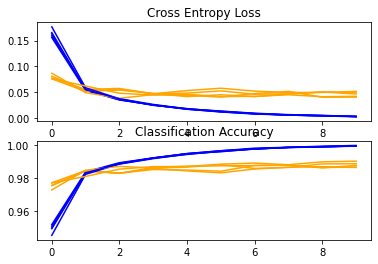

Accuracy: mean=98.800 std=0.142, n=5


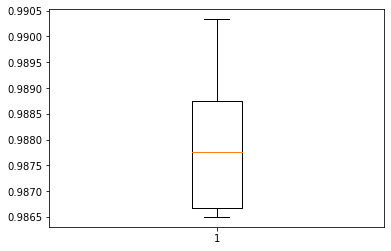

In [9]:
#learning curves
summarise(histories)
#summarize estimated performance
summariseModel(scores)

Testing parameter notes for the base model (2 folds) (compared to mean accuracy): <br>
Learning rate: <br>
- 0.1 rate = 96.793%
- 0.01 rate = 98.608%
- 0.05 rate = 98.423%
<br>
Therefore 0.01 rate is optimal
<br><br>
Feature maps:
- 32 maps = 98.608%
- 64 maps = 98.380%
- 16 maps = 98.358% <br>
Therefore 32 maps is optimal
<br> <br>
Filter size:
- 3x3 size = 98.608%
- 1x1 size = 96.473%
- 5x5 size = 98.767% <br>
Therefore a filter size of 5x5 is optimal
<br><br>
Density:
- 100 nodes = 98.767%
- 50 nodes = 98.520%
- 200 nodes  = 98.650% <br>
Therefore 100 nodes is optimal

## Batch Normalisation

To improve the base model, batch normalisation is used to change the distribution of the output layer, by standardising the outputs.

In [8]:
#define model
def defineBNModel():
    model = Sequential()
    #setup number of filters, filter size, relu
    model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    #flatten
    model.add(Flatten())
    #100 nodes, using relu
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    #using softmax for the 10 nodes
    model.add(Dense(10, activation='softmax'))
    # compile
    #learning rate and momentum
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

ERROR! Session/line number was not unique in database. History logging moved to new session 162


In [9]:
#evaluate model, with 5 folds
def evaluateBNModel(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    #cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    #enumerating splits
    for train_ix, test_ix in kfold.split(dataX):
        #define model
        model = defineBNModel()
        #training and testing rows
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        #fit model, epochs, batch size
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        #evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        #stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

In [13]:
#load dataset
trainX, trainY, testX, testY = loadMNIST()
#prepare pixel data
trainX, testX = pixel(trainX, testX)
#evaluate model
scores, histories = evaluateBNModel(trainX, trainY)

MNIST loaded
> 98.792
> 98.725
> 98.783
> 98.958
> 98.800


C:\Users\issac\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
C:\Users\issac\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


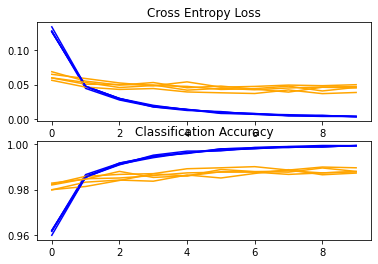

Accuracy: mean=98.812 std=0.078, n=5


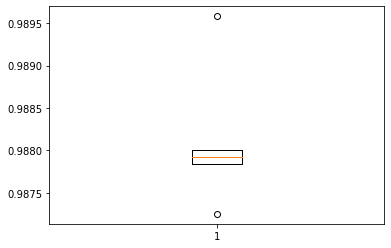

In [15]:
#learning curves
summarise(histories)
#summarize estimated performance
summariseModel(scores)

For batch normalisation, the learning rate will be tested (2 fold):
- 0.01 = 98.710%
- 0.1 = 98.490%
- 0.05 = 98.427% <br>
Therefore a learning rate of 0.01 is still optimal

## Dropout

To improve the model, we will use dropout. By testing and viewing other examples, we will use 40% dropout. : <br>
https://www.kaggle.com/code/cdeotte/how-to-choose-cnn-architecture-mnist/notebook

In [16]:
#define model
def defineDOModel():
    #Dropout amount
    dropped = 0.4
    model = Sequential()
    #setup number of filters, filter size, relu
    model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropped))
    #flatten
    model.add(Flatten())
    #100 nodes, using relu
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(dropped))
    #using softmax for the 10 nodes
    model.add(Dense(10, activation='softmax'))
    # compile
    #learning rate and momentum
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

ERROR! Session/line number was not unique in database. History logging moved to new session 164


In [19]:
#evaluate model, with 5 folds
def evaluateDOModel(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        #define model
        model = defineDOModel()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model, epochs, batch size
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

In [20]:
#load dataset
trainX, trainY, testX, testY = loadMNIST()
#prepare pixel data
trainX, testX = pixel(trainX, testX)
#evaluate model
scores, histories = evaluateDOModel(trainX, trainY)

MNIST loaded
> 98.725
> 98.892
> 98.817
> 98.908
> 98.800


C:\Users\issac\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
C:\Users\issac\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


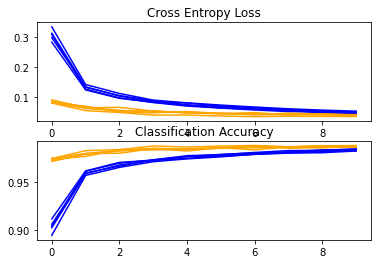

Accuracy: mean=98.828 std=0.066, n=5


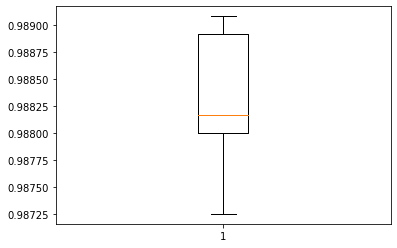

In [21]:
#learning curves
summarise(histories)
#summarize estimated performance
summariseModel(scores)

For dropout, the amount dropped will be tested:
- 0.5 = 98.523% 
- 0.4 = 98.850%
- 0.3 = 98.593%
- 0.2 = 98.733%
- 0.1 = 98.690%<br>
Therfore a dropout amount of 0.4 is optimal

In [10]:
print("end")

end
